In [1]:
%run config.ipynb
# %run keras-bert.py
import os
import random
import math
import tensorflow as tf
import tensorflow_hub as hub

from official.modeling import tf_utils
from official import nlp
from official.nlp import optimization
from official.nlp import bert
from official.nlp.bert.tokenization import FullTokenizer
from official.nlp.bert.configs import BertConfig
from official.nlp.bert.bert_models import classifier_model

from keras_bert.bert import get_model
from keras_bert.loader import load_trained_model_from_checkpoint

from transformers import BertForSequenceClassification
from transformers import BertTokenizer

import tensorflow as tf
print("Num GPUs Available: ", tf.config.experimental.list_physical_devices('GPU'))
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Dense, Embedding, LSTM, Bidirectional, GlobalMaxPooling1D, GlobalAveragePooling1D, Dropout, Conv1D, GlobalMaxPool1D, GlobalAvgPool1D
from tensorflow.keras.models import Model, clone_model, Sequential
from tensorflow.keras.metrics import RootMeanSquaredError

import json

# from keras import backend as K

Num GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
df = pd.read_csv("data/yelp_academic_dataset_sample005_filter.csv")
df.head(1)

,review_id,user_id,business_id,review_stars,review_text,review_text_after_cleaning,user_review_count,user_elite,user_friends,user_fans,user_average_stars,user_total_compliments,business_name,business_categories,business_stars,to_recommend,num_user_friends
0,yNB39szX3M8mTEzTtsgoCw,Y1iCYGvLf4ifPoXlKLGq-w,o2Qh4SiGYJ7BK4hP7dfkrw,5,This is an amazing indian Bistro!!I If I do sa...,amaz bistroi say myself never cuisin glad expe...,1,0,None,0,5.0,0,Saffron Indian Bistro,"Restaurants, Indian",4.5,True,0


<AxesSubplot:xlabel='text_len', ylabel='size'>

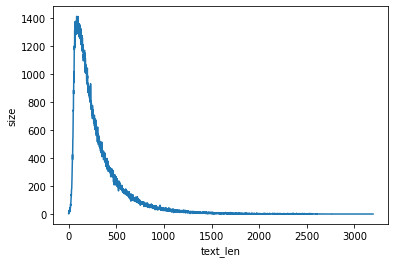

In [9]:
df["text_len"] = df["review_text_after_cleaning"].apply(len)
text_length = df.groupby("text_len", as_index=False).size()
sns.lineplot(x="text_len", y="size", data=text_length)

<AxesSubplot:xlabel='num_words', ylabel='size'>

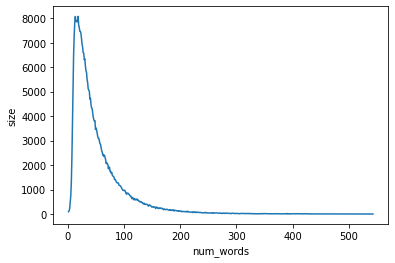

In [13]:
def num_word(data):
    return len(data.split(" "))
df["num_words"] = df["review_text_after_cleaning"].apply(num_word)
num_words = df.groupby("num_words", as_index=False).size()
sns.lineplot(x="num_words", y="size", data=num_words)

Right-Skewed

<AxesSubplot:xlabel='num_words', ylabel='size'>

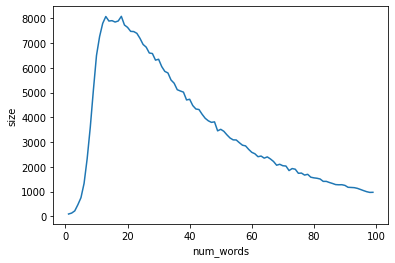

In [14]:
sns.lineplot(x="num_words", y="size", data=num_words[num_words["num_words"] < 100])

In [5]:
def num_word(data):
    return len(data.split(" "))
X = df["review_text_after_cleaning"].apply(lambda x : x if num_word(x) < 110 else ' '.join(x.split(" ")[:110]))
y = df["review_stars"].apply(lambda x : x-1)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [7]:
bert_folder = "data/bert_custom/"
tf.io.gfile.listdir(bert_folder)

['bert_config.json',
 'bert_model.ckpt.data-00000-of-00001',
 'bert_model.ckpt.index',
 'vocab.txt']

In [6]:
# Set up tokenizer to generate Tensorflow dataset
tokenizer = bert.tokenization.FullTokenizer(vocab_file=os.path.join(bert_folder, "vocab.txt"), do_lower_case=True)
print("Vocab size:", len(tokenizer.vocab))

Vocab size: 30522


In [8]:
def tokenize_review(text):
    return tokenizer.convert_tokens_to_ids(tokenizer.tokenize(text))
tokenized_reviews = X_train.apply(tokenize_review)

In [9]:
reviews_with_len = [[review, y[i], len(review)] for i, review in enumerate(tokenized_reviews)]
reviews_with_len[0]

[[6187,
  2271,
  2868,
  9530,
  15900,
  2072,
  7661,
  3805,
  25540,
  8490,
  9530,
  14028,
  2296,
  2239,
  4297,
  7630,
  2094,
  2033,
  2187,
  2868],
 5,
 20]

In [10]:
random.shuffle(reviews_with_len)
reviews_with_len.sort(key=lambda x: x[2])

In [11]:
sorted_reviews_labels = [(review_lab[0], review_lab[1]) for review_lab in reviews_with_len]
sorted_reviews_labels

[([2182], 1),
 ([2293], 3),
 ([4497], 5),
 ([2204], 5),
 ([2307], 4),
 ([2485], 5),
 ([2237], 4),
 ([24970], 5),
 ([2067], 1),
 ([24970], 2),
 ([1058], 5),
 ([2732], 4),
 ([3435], 5),
 ([2485], 5),
 ([4900], 4),
 ([3435], 2),
 ([3095], 5),
 ([2205], 1),
 ([2514], 5),
 ([7929], 3),
 ([2168], 5),
 ([14123], 2),
 ([2769], 4),
 ([3199], 2),
 ([8288], 5),
 ([5404], 5),
 ([1047], 5),
 ([3819], 5),
 ([8257], 3),
 ([24970], 5),
 ([2560], 5),
 ([6187], 2),
 ([2173], 1),
 ([14262, 7903], 5),
 ([7563, 17728], 4),
 ([5932, 10497], 1),
 ([2502, 4664], 5),
 ([7610, 2330], 2),
 ([15536, 8873], 4),
 ([2191, 11132], 1),
 ([2106, 10036], 2),
 ([17935, 3775], 2),
 ([2485, 2204], 4),
 ([13173, 6559], 3),
 ([22448, 15916], 5),
 ([2739, 4149], 3),
 ([4190, 4183], 4),
 ([3976, 2092], 2),
 ([2564, 4060], 5),
 ([2522, 9236], 4),
 ([15180, 25426], 5),
 ([17268, 4664], 5),
 ([4550, 4355], 4),
 ([4550, 4067], 4),
 ([1037, 4239], 5),
 ([9805, 2213], 4),
 ([3976, 2833], 2),
 ([2175, 2237], 5),
 ([15180, 25426], 5),

In [39]:
processed_dataset = tf.data.Dataset.from_generator(lambda: sorted_reviews_labels, output_types=(tf.int32, tf.float32))
BATCH_SIZE = 256
batched_dataset = processed_dataset.padded_batch(BATCH_SIZE, padded_shapes=((None, ), ()))
next(iter(batched_dataset))

(<tf.Tensor: shape=(256, 4), dtype=int32, numpy=
 array([[ 2182,     0,     0,     0],
        [ 2293,     0,     0,     0],
        [ 4497,     0,     0,     0],
        ...,
        [ 2293,  4748,  2953,  2173],
        [ 3435,  2767,  3669,  2709],
        [ 2247,  2395, 14980,  7140]])>,
 <tf.Tensor: shape=(256,), dtype=float32, numpy=
 array([1., 3., 5., 5., 4., 5., 4., 5., 1., 2., 5., 4., 5., 5., 4., 2., 5.,
        1., 5., 3., 5., 2., 4., 2., 5., 5., 5., 5., 3., 5., 5., 2., 1., 5.,
        4., 1., 5., 2., 4., 1., 2., 2., 4., 3., 5., 3., 4., 2., 5., 4., 5.,
        5., 4., 4., 5., 4., 2., 5., 5., 5., 3., 5., 4., 4., 5., 5., 4., 4.,
        3., 4., 1., 4., 5., 3., 5., 3., 5., 4., 2., 4., 5., 4., 5., 3., 5.,
        5., 3., 4., 5., 4., 4., 4., 1., 2., 5., 1., 5., 4., 1., 2., 4., 5.,
        4., 5., 5., 5., 5., 2., 5., 5., 2., 4., 4., 5., 1., 5., 1., 4., 3.,
        5., 4., 4., 4., 4., 2., 5., 4., 4., 5., 3., 5., 5., 4., 5., 4., 5.,
        2., 5., 4., 3., 5., 3., 5., 5., 5., 3., 5.

In [40]:
TOTAL_BATCHES = math.ceil(len(sorted_reviews_labels) / BATCH_SIZE)
TEST_BATCHES = TOTAL_BATCHES // 16
batched_dataset.shuffle(TOTAL_BATCHES)
test_data = batched_dataset.take(TEST_BATCHES)
train_data = batched_dataset.skip(TEST_BATCHES)

In [49]:
class TEXT_MODEL(tf.keras.Model):
    
    def __init__(self, vocabulary_size, embedding_dimensions=150, dnn_units=128,
                 dropout_rate=0.2, training=False,  name="bert_model"):
        
        super(TEXT_MODEL, self).__init__(name=name)
        
        self.embedding = Embedding(vocabulary_size, embedding_dimensions)
        self.rnn_layer1 = Bidirectional(LSTM(50, dropout=dropout_rate, return_sequences=True))
        self.pooling = GlobalAveragePooling1D()
        self.last_dense = Dense(1)
    
    def call(self, inputs, training):
        x = self.embedding(inputs)
        x = self.rnn_layer1(x)
        x = self.pooling(x)
        x = self.last_dense(x)
        
        return x

In [50]:
bert_model = TEXT_MODEL(vocabulary_size=len(tokenizer.vocab))
bert_model.compile(loss="mse", optimizer="adam", metrics=['mae', RootMeanSquaredError('rmse')])
bert_model.fit(train_data, epochs=5)

Epoch 1/5
984/984 [==============================] - 61s 62ms/step - loss: 2.2306 - mae: 1.2325 - rmse: 1.4935
Epoch 2/5
984/984 [==============================] - 62s 63ms/step - loss: 2.0044 - mae: 1.1889 - rmse: 1.4158
Epoch 3/5
984/984 [==============================] - 62s 63ms/step - loss: 1.9859 - mae: 1.1806 - rmse: 1.4092
Epoch 4/5
984/984 [==============================] - 62s 63ms/step - loss: 1.9640 - mae: 1.1703 - rmse: 1.4014
Epoch 5/5
984/984 [==============================] - 62s 63ms/step - loss: 1.9404 - mae: 1.1599 - rmse: 1.3930


In [29]:
bert_model.evaluate(test_data)

65/65 [==============================] - 1s 21ms/step - loss: 2.9043 - mae: 1.5362 - rmse: 1.6715


[2.9042723178863525, 1.5361770391464233, 1.6715201139450073]

# Fine-tuning

In [8]:
# Set up tokenizer to generate Tensorflow dataset
tokenizer = bert.tokenization.FullTokenizer(vocab_file=os.path.join(bert_folder, "vocab.txt"), do_lower_case=True)
print("Vocab size:", len(tokenizer.vocab))

Vocab size: 30522


In [9]:
def encode_sentence(s, tokenizer):
   tokens = list(tokenizer.tokenize(s))
   tokens.append('[SEP]')
   return tokenizer.convert_tokens_to_ids(tokens)

def bert_encode(X, tokenizer):
  num_examples = len(X)
  
  sentence1 = tf.ragged.constant([encode_sentence(s, tokenizer) for s in np.array(X)])

#   sentence2 = tf.ragged.constant([
#       encode_sentence(s, tokenizer)
#        for s in np.array(glue_dict["sentence2"])])

  cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*sentence1.shape[0]
  input_word_ids = tf.concat([cls, sentence1], axis=-1)

  input_mask = tf.ones_like(input_word_ids).to_tensor()

  type_cls = tf.zeros_like(cls)
  type_s1 = tf.zeros_like(sentence1)
#   type_s2 = tf.ones_like(sentence2)
  input_type_ids = tf.concat([type_cls, type_s1], axis=-1).to_tensor()

  inputs = {
      'input_word_ids': input_word_ids.to_tensor(),
      'input_mask': input_mask,
      'input_type_ids': input_type_ids}

  return inputs

X_train = bert_encode(X_train, tokenizer)
X_test = bert_encode(X_test, tokenizer)
# X = bert_encode(X, tokenizer)

In [10]:
for key, value in X_train.items():
  print(f'{key:15s} shape: {value.shape}')

print(f'X_train_labels shape: {y_train.shape}')

for key, value in X_test.items():
  print(f'{key:15s} shape: {value.shape}')

print(f'X_train_labels shape: {y_test.shape}')

input_word_ids  shape: (268540, 226)
input_mask      shape: (268540, 226)
input_type_ids  shape: (268540, 226)
X_train_labels shape: (268540,)
input_word_ids  shape: (132267, 243)
input_mask      shape: (132267, 243)
input_type_ids  shape: (132267, 243)
X_train_labels shape: (132267,)


In [18]:
for key, value in X_train.items():
  print(f'{key:15s} shape: {value.shape}')

print(f'X_train_labels shape: {y_train.shape}')

input_word_ids  shape: (268540, 921)
input_mask      shape: (268540, 921)
input_type_ids  shape: (268540, 921)
X_train_labels shape: (268540,)


In [19]:
for key, value in X_test.items():
  print(f'{key:15s} shape: {value.shape}')

print(f'X_train_labels shape: {y_test.shape}')

input_word_ids  shape: (132267, 716)
input_mask      shape: (132267, 716)
input_type_ids  shape: (132267, 716)
X_train_labels shape: (132267,)


# Tiny Bert

In [31]:
bert_config_file = os.path.join(bert_folder, "bert_config.json")
config_dict = json.loads(tf.io.gfile.GFile(bert_config_file).read())
bert_config = bert.configs.BertConfig.from_dict(config_dict)
config_dict

{'hidden_size': 128,
 'hidden_act': 'gelu',
 'initializer_range': 0.02,
 'vocab_size': 30522,
 'hidden_dropout_prob': 0.1,
 'num_attention_heads': 2,
 'type_vocab_size': 2,
 'max_position_embeddings': 1024,
 'num_hidden_layers': 2,
 'intermediate_size': 512,
 'attention_probs_dropout_prob': 0.1}

In [24]:
bert_classifier, bert_encoder = bert.bert_models.classifier_model(bert_config, num_labels=2)

In [12]:
# Set up epochs and steps
epochs = 5
batch_size = 128
eval_batch_size = 32

train_data_size = len(y_train)
steps_per_epoch = int(train_data_size / batch_size)
num_train_steps = steps_per_epoch * epochs
warmup_steps = int(epochs * train_data_size * 0.1 / batch_size)

# creates an optimizer with learning rate schedule
optimizer = nlp.optimization.create_optimizer(2e-5, num_train_steps=num_train_steps, num_warmup_steps=warmup_steps)

INFO:absl:using Adamw optimizer


In [14]:
metrics = [tf.keras.metrics.RootMeanSquaredError('rmse'), 'mae']
loss = tf.keras.losses.MeanSquaredError(name='mse')

bert_classifier.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metrics)

bert_classifier.fit(
      X_train, y_train,
      validation_data=(X_test, y_test),
      batch_size=128,
      epochs=epochs)

Epoch 1/5
2098/2098 [==============================] - 593s 282ms/step - loss: 5.2953 - rmse: 2.3012 - mae: 1.9360 - val_loss: 2.2311 - val_rmse: 1.4937 - val_mae: 1.2983
Epoch 2/5
2098/2098 [==============================] - 596s 284ms/step - loss: 2.2304 - rmse: 1.4935 - mae: 1.2866 - val_loss: 2.1574 - val_rmse: 1.4688 - val_mae: 1.2795
Epoch 3/5
2098/2098 [==============================] - 596s 284ms/step - loss: 1.6962 - rmse: 1.3024 - mae: 1.1024 - val_loss: 1.5917 - val_rmse: 1.2616 - val_mae: 1.0497
Epoch 4/5
2098/2098 [==============================] - 600s 286ms/step - loss: 1.6327 - rmse: 1.2778 - mae: 1.0731 - val_loss: 1.5917 - val_rmse: 1.2616 - val_mae: 1.0497
Epoch 5/5
2098/2098 [==============================] - 598s 285ms/step - loss: 1.6325 - rmse: 1.2777 - mae: 1.0729 - val_loss: 1.5917 - val_rmse: 1.2616 - val_mae: 1.0497


# Mini Bert

### Adam Opti

In [149]:
bert_config_file = os.path.join(bert_folder, "bert_config.json")
config_dict = json.loads(tf.io.gfile.GFile(bert_config_file).read())
bert_config = bert.configs.BertConfig.from_dict(config_dict)
config_dict

{'hidden_size': 256,
 'hidden_act': 'gelu',
 'initializer_range': 0.02,
 'vocab_size': 30522,
 'hidden_dropout_prob': 0.1,
 'num_attention_heads': 4,
 'type_vocab_size': 2,
 'max_position_embeddings': 256,
 'num_hidden_layers': 4,
 'intermediate_size': 1024,
 'attention_probs_dropout_prob': 0.1}

In [150]:
bert_classifier, bert_encoder = bert.bert_models.classifier_model(bert_config, num_labels=1)

In [67]:
bert_classifier.compile(
    optimizer='adam',
    loss='mse',
    metrics=[tf.keras.metrics.RootMeanSquaredError('rmse'), 'mae'])

bert_classifier.fit(
      X_train, y_train,
      validation_data=(X_test, y_test),
      batch_size=128,
      epochs=3)

Epoch 1/3
2098/2098 [==============================] - 564s 269ms/step - loss: 2.1396 - rmse: 1.4627 - mae: 1.2421 - val_loss: 2.2319 - val_rmse: 1.4939 - val_mae: 1.2715
Epoch 2/3
2098/2098 [==============================] - 588s 280ms/step - loss: 2.2351 - rmse: 1.4950 - mae: 1.2835 - val_loss: 2.2383 - val_rmse: 1.4961 - val_mae: 1.2578
Epoch 3/3
2098/2098 [==============================] - 592s 282ms/step - loss: 2.2337 - rmse: 1.4946 - mae: 1.2827 - val_loss: 2.2361 - val_rmse: 1.4953 - val_mae: 1.3118


In [68]:
bert_classifier, bert_encoder = bert.bert_models.classifier_model(bert_config, num_labels=2)
bert_classifier.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError('rmse'), 'mae'])
bert_classifier.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=128, epochs=3)

Epoch 1/3
2098/2098 [==============================] - 591s 281ms/step - loss: 2.2424 - rmse: 1.4975 - mae: 1.2846 - val_loss: 2.2495 - val_rmse: 1.4998 - val_mae: 1.2432
Epoch 2/3
2098/2098 [==============================] - 592s 282ms/step - loss: 2.2334 - rmse: 1.4945 - mae: 1.2830 - val_loss: 2.2564 - val_rmse: 1.5021 - val_mae: 1.3373
Epoch 3/3
2098/2098 [==============================] - 592s 282ms/step - loss: 2.2333 - rmse: 1.4944 - mae: 1.2831 - val_loss: 2.2417 - val_rmse: 1.4972 - val_mae: 1.2526


In [78]:
bert_classifier, bert_encoder = bert.bert_models.classifier_model(bert_config, num_labels=5)
bert_classifier.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError('rmse'), 'mae'])
bert_classifier.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=128, epochs=3)

Epoch 1/3
2098/2098 [==============================] - 608s 290ms/step - loss: 2.2800 - rmse: 1.5100 - mae: 1.2913 - val_loss: 2.2335 - val_rmse: 1.4945 - val_mae: 1.3063
Epoch 2/3
2098/2098 [==============================] - 609s 290ms/step - loss: 2.2360 - rmse: 1.4953 - mae: 1.2836 - val_loss: 2.2327 - val_rmse: 1.4942 - val_mae: 1.2693
Epoch 3/3
2098/2098 [==============================] - 614s 293ms/step - loss: 2.2338 - rmse: 1.4946 - mae: 1.2824 - val_loss: 2.2304 - val_rmse: 1.4934 - val_mae: 1.2961


### AdamW Opti

In [151]:
# Set up epochs and steps
epochs = 3
batch_size = 128
eval_batch_size = 32

train_data_size = len(y_train)
steps_per_epoch = int(train_data_size / batch_size)
num_train_steps = steps_per_epoch * epochs
warmup_steps = int(epochs * train_data_size * 0.1 / batch_size)

# creates an optimizer with learning rate schedule
optimizer = nlp.optimization.create_optimizer(2e-5, num_train_steps=num_train_steps, num_warmup_steps=warmup_steps)

INFO:absl:using Adamw optimizer


In [152]:
bert_classifier, bert_encoder = bert.bert_models.classifier_model(bert_config, num_labels=5)
bert_classifier.compile(optimizer=optimizer, loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError('rmse'), 'mae'])
bert_classifier.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=batch_size, epochs=epochs)

Epoch 1/3
2098/2098 [==============================] - 606s 289ms/step - loss: 2.8244 - rmse: 1.6806 - mae: 1.3796 - val_loss: 0.7311 - val_rmse: 0.8551 - val_mae: 0.6533
Epoch 2/3
2098/2098 [==============================] - 610s 291ms/step - loss: 0.6970 - rmse: 0.8348 - mae: 0.6267 - val_loss: 0.6556 - val_rmse: 0.8097 - val_mae: 0.5974
Epoch 3/3
2098/2098 [==============================] - 619s 295ms/step - loss: 0.6508 - rmse: 0.8067 - mae: 0.5984 - val_loss: 0.6436 - val_rmse: 0.8022 - val_mae: 0.5818


# Custom Bert

In [27]:
# Set up epochs and steps
epochs = 3
batch_size = 128
eval_batch_size = 32

train_data_size = len(y_train)
steps_per_epoch = int(train_data_size / batch_size)
num_train_steps = steps_per_epoch * epochs
warmup_steps = int(epochs * train_data_size * 0.1 / batch_size)

# creates an optimizer with learning rate schedule
optimizer = nlp.optimization.create_optimizer(2e-4, num_train_steps=num_train_steps, num_warmup_steps=warmup_steps)

INFO:absl:using Adamw optimizer


In [28]:
bert_config_file = os.path.join(bert_folder, "bert_config.json")
config_dict = json.loads(tf.io.gfile.GFile(bert_config_file).read())
bert_config = bert.configs.BertConfig.from_dict(config_dict)
config_dict

{'hidden_size': 320,
 'hidden_act': 'gelu',
 'initializer_range': 0.02,
 'vocab_size': 30522,
 'hidden_dropout_prob': 0.1,
 'num_attention_heads': 4,
 'type_vocab_size': 2,
 'max_position_embeddings': 256,
 'num_hidden_layers': 4,
 'intermediate_size': 1024,
 'attention_probs_dropout_prob': 0.1}

In [29]:
bert_classifier, bert_encoder = bert.bert_models.classifier_model(bert_config, num_labels=5)
bert_classifier.compile(optimizer=optimizer, loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError('rmse'), 'mae'])
bert_classifier.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=batch_size, epochs=epochs)

Epoch 1/3
2098/2098 [==============================] - 774s 369ms/step - loss: 1.2053 - rmse: 1.0979 - mae: 0.7785 - val_loss: 0.5880 - val_rmse: 0.7668 - val_mae: 0.5117
Epoch 2/3
2098/2098 [==============================] - 772s 368ms/step - loss: 0.5581 - rmse: 0.7471 - mae: 0.5206 - val_loss: 0.5703 - val_rmse: 0.7552 - val_mae: 0.5077
Epoch 3/3
2098/2098 [==============================] - 774s 369ms/step - loss: 0.4944 - rmse: 0.7032 - mae: 0.4847 - val_loss: 0.5613 - val_rmse: 0.7492 - val_mae: 0.4898


In [31]:
bert_config_file = os.path.join(bert_folder, "bert_config.json")
config_dict = json.loads(tf.io.gfile.GFile(bert_config_file).read())
bert_config = bert.configs.BertConfig.from_dict(config_dict)
config_dict

{'hidden_size': 320,
 'hidden_act': 'gelu',
 'initializer_range': 0.02,
 'vocab_size': 30522,
 'hidden_dropout_prob': 0.1,
 'num_attention_heads': 4,
 'type_vocab_size': 2,
 'max_position_embeddings': 256,
 'num_hidden_layers': 4,
 'intermediate_size': 1024,
 'attention_probs_dropout_prob': 0.1}

In [32]:
# creates an optimizer with learning rate schedule
optimizer = nlp.optimization.create_optimizer(8e-4, num_train_steps=num_train_steps, num_warmup_steps=warmup_steps)

bert_classifier, bert_encoder = bert.bert_models.classifier_model(bert_config, num_labels=5)
bert_classifier.compile(optimizer=optimizer, loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError('rmse'), 'mae'])
bert_classifier.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=batch_size, epochs=epochs)

INFO:absl:using Adamw optimizer


Epoch 1/3
2098/2098 [==============================] - 762s 363ms/step - loss: 0.9887 - rmse: 0.9943 - mae: 0.7039 - val_loss: 0.6490 - val_rmse: 0.8056 - val_mae: 0.5890
Epoch 2/3
2098/2098 [==============================] - 777s 370ms/step - loss: 0.5586 - rmse: 0.7474 - mae: 0.5217 - val_loss: 0.5753 - val_rmse: 0.7585 - val_mae: 0.5156
Epoch 3/3
2098/2098 [==============================] - 776s 370ms/step - loss: 0.4645 - rmse: 0.6816 - mae: 0.4704 - val_loss: 0.5623 - val_rmse: 0.7499 - val_mae: 0.4929


In [33]:
# creates an optimizer with learning rate schedule
optimizer = nlp.optimization.create_optimizer(5e-4, num_train_steps=num_train_steps, num_warmup_steps=warmup_steps)

bert_classifier, bert_encoder = bert.bert_models.classifier_model(bert_config, num_labels=5)
bert_classifier.compile(optimizer=optimizer, loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError('rmse'), 'mae'])
bert_classifier.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=batch_size, epochs=epochs)

INFO:absl:using Adamw optimizer


Epoch 1/3
2098/2098 [==============================] - 752s 358ms/step - loss: 1.0371 - rmse: 1.0184 - mae: 0.7179 - val_loss: 0.5951 - val_rmse: 0.7714 - val_mae: 0.5283
Epoch 2/3
2098/2098 [==============================] - 746s 355ms/step - loss: 0.5486 - rmse: 0.7407 - mae: 0.5158 - val_loss: 0.5719 - val_rmse: 0.7562 - val_mae: 0.5025
Epoch 3/3
2098/2098 [==============================] - 746s 355ms/step - loss: 0.4626 - rmse: 0.6802 - mae: 0.4693 - val_loss: 0.5617 - val_rmse: 0.7495 - val_mae: 0.4860


In [ ]:
# creates an optimizer with learning rate schedule
optimizer = nlp.optimization.create_optimizer(5e-4, num_train_steps=num_train_steps, num_warmup_steps=warmup_steps)

bert_classifier, bert_encoder = bert.bert_models.classifier_model(bert_config, num_labels=1)
bert_classifier.compile(optimizer=optimizer, loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError('rmse'), 'mae'])
bert_classifier.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=batch_size, epochs=epochs)

INFO:absl:using Adamw optimizer


Epoch 1/3
 190/2098 [=>............................] - ETA: 9:38 - loss: 3.2865 - rmse: 1.8129 - mae: 1.5322

### Change dropout rate to 0.2

# Bert Embeddings

In [137]:
max_seq_length = 150
# Create datasets (Only take up to max_seq_length words for memory)
train_text = X_train.tolist()
train_text = [" ".join(t.split()[0:max_seq_length]) for t in train_text]
train_text = np.array(train_text, dtype=object)[:, np.newaxis]
train_label = y_train.tolist()

test_text = X_test.tolist()
test_text = [" ".join(t.split()[0:max_seq_length]) for t in test_text]
test_text = np.array(test_text, dtype=object)[:, np.newaxis]
test_label = y_test.tolist()

In [138]:

# Set up tokenizer to generate Tensorflow dataset
tokenizer = bert.tokenization.FullTokenizer(vocab_file=os.path.join(bert_folder, "vocab.txt"), do_lower_case=True)
print("Vocab size:", len(tokenizer.vocab))

# Convert data to InputExample format
train_examples = convert_text_to_examples(X_train, y_train)
test_examples = convert_text_to_examples(X_test, y_test)

# Convert to features
(train_input_ids, train_input_masks, train_segment_ids, train_labels) = convert_examples_to_features(tokenizer, train_examples, max_seq_length=150)
(test_input_ids, test_input_masks, test_segment_ids, test_labels) = convert_examples_to_features(tokenizer, test_examples, max_seq_length=150)

Vocab size: 30522


Converting examples to features: 100%|████████████████████████████████████████| 132267/132267 [02:39<00:00, 831.33it/s]


In [141]:
# Build model
def build_model(max_seq_length):
    in_id = tf.keras.layers.Input(shape=(max_seq_length,), name="input_ids")
    in_mask = tf.keras.layers.Input(shape=(max_seq_length,), name="input_masks")
    in_segment = tf.keras.layers.Input(shape=(max_seq_length,), name="segment_ids")
    bert_inputs = [in_id, in_mask, in_segment]

    bert_output = BertLayer(n_fine_tune_layers=3)(bert_inputs)
    dense = tf.keras.layers.Dense(256, activation="relu")(bert_output)
    pred = tf.keras.layers.Dense(1, activation="sigmoid")(dense)

    model = tf.keras.models.Model(inputs=bert_inputs, outputs=pred)
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
    model.summary()

    return model

# Reference

https://www.tensorflow.org/official_models/fine_tuning_bert

https://stackabuse.com/text-classification-with-bert-tokenizer-and-tf-2-0-in-python/